In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

# load the data
# IMPORTING DATA 
raw_store_data=pd.read_csv('data/store.csv',low_memory=False )
raw_train_data=pd.read_csv('data/train.csv', low_memory=False, )
raw_test_data=pd.read_csv('data/test.csv',  low_memory=False,)

#copying dataframes
dfTrain = raw_train_data.copy()
dfTest = raw_test_data.copy()
dfStore = raw_store_data.copy()

# dropping the zero sales and closed stores
dfTrain = dfTrain[(dfTrain.Open != 0) & (dfTrain.Sales != 0)]

# filling the NaN values in CompetitionDistance col
dfStore.CompetitionDistance.fillna(dfStore.CompetitionDistance.median(), inplace=True)

# replace all the other NaN values with zeros
dfStore.fillna(0, inplace=True)

# fill the missing values
dfTest.fillna(1, inplace=True)

# merge train and test dataset with store data
def merge(df, store):
    dfJoined = pd.merge(df, store, how='inner', on='Store')
    return dfJoined
dfTrainStore = merge(dfTrain, dfStore)
dfTestStore = merge(dfTest, dfStore)

# Set the target column
Y = dfTrainStore['Sales']
Id = dfTestStore['Id']

# remove dataset specific columns
dfTrainStore = dfTrainStore.drop(['Customers', 'Sales'], axis=1)
dfTestStore = dfTestStore.drop(['Id'], axis=1)

# split the train data into training and validation sets
xTrain, xTrainTest, yTrain, yTrainTest = train_test_split(dfTrainStore, Y, test_size=0.20, random_state=42)

In [5]:
import logging
from sklearn.base import BaseEstimator, TransformerMixin

form = logging.Formatter("%(asctime)s : %(levelname)-5.5s : %(message)s")
logger = logging.getLogger()


consoleHandler = logging.StreamHandler()
consoleHandler.setFormatter(form)
logger.addHandler(consoleHandler)

logger.setLevel(logging.DEBUG)


class multipleTransformer(BaseEstimator, TransformerMixin):
    '''This Class is for running user defined functions in the Pipeline function from sklearn
       The pipeline function requires a class to run user defined functions'''
    def __init__(self):
        logger.info('\n >>>>> init() called. \n')

    def fit(self, X, y=None):
        logger.info('\n >>>>> fit() called. \n')
        return self

    # add aditional columns to the dataset.
    def dataTuning(self, df):
        logger.info('\n creating the data Year, Month, Week of Year columns \n')
        df['Date'] = pd.to_datetime(df.Date)
        df.set_index('Date', inplace=True)
        df['Year'] = df.index.year
        df['Month'] = df.index.month
        df['WeekOfYear'] = df.index.weekofyear

        return df

    # Create dummy variables instead of binary encoding to avoid uneven weight distribution in the categorical cols
    def createDummies(self, df):
        logger.info('\n Creating Dummie columns ')
        df = pd.get_dummies(df, columns=["Assortment", "StoreType", "PromoInterval"],
                            prefix=["is_Assortment", "is_StoreType", "is_PromoInteval"])
        return df

    # creates a new column that combines the CompetitionOpenSinceMonth and CompetitionOpenSinceYear columns
    def compeSince(self, df):
        logger.info('\n running CompeSince \n')
        df['CompetitionOpenSince'] = np.where((df['CompetitionOpenSinceMonth'] == 0) &
                                              (df['CompetitionOpenSinceYear'] == 0), 0,
                                              (df.Month - df.CompetitionOpenSinceMonth) +
                                              (12 * (df.Year - df.CompetitionOpenSinceYear)))
        return df

    # This function sets various columns into categorical
    def setCat(self, df):
        logger.info('\n running Set to Category \n')
        df['StateHoliday'] = df['StateHoliday'].astype('category')
        df['Assortment'] = df['Assortment'].astype('category')
        df['StoreType'] = df['StoreType'].astype('category')
        df['PromoInterval'] = df['PromoInterval'].astype('category')

        return df

    # change stateHoliday to 0 1 values
    def stateHol(self, df):
        logger.info('\n Change state Holiday to 0 and 1 \n')
        df["is_holiday_state"] = df['StateHoliday'].map({"0": 0, "a": 1, "b": 1, "c": 1})
        return df

    # this function drops columns
    def dropCol(self, df):
        logger.info('\n dropping unecessary columns \n')
        df = df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'StateHoliday'], axis=1)
        return df

    def transform(self, X, y=None):
        logger.info("\n the transform function has been called \n")

        X = self.dataTuning(X)
        X = self.compeSince(X)
        X = self.setCat(X)
        X = self.stateHol(X)
        X = self.createDummies(X)
        X = self.dropCol(X)
        
        self.X = X
        
        return X
    
    def returndf(self):
        return self.X



# transform the target column
def targetTransform(target):
    logger.info('\n transforming the target Column \n')
    target = np.log(target)
    return target

# reverse target transform
def reverseTargetTransform(target):
    logger.info('\n reverse transforming the target col \n')
    target = np.exp(target)
    return target

#### model building

In [6]:
# Pipeline for creating the model and transforming columns
pipe = Pipeline(steps=[
        ('multipleTrans', multipleTransformer()),
        ('randomForest', RandomForestRegressor(n_estimators=128,
                                               criterion='mse',
                                               max_depth=20,
                                               min_samples_split=10,
                                               min_samples_leaf=1,
                                               min_weight_fraction_leaf=0.0,
                                               max_features='auto',
                                               max_leaf_nodes=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               bootstrap=True,
                                               oob_score=False,
                                               n_jobs=4,
                                               random_state=35,
                                               verbose=0,
                                               warm_start=False))
    ])

# pipeline for target transformation
regModel = TransformedTargetRegressor(regressor=pipe, func=targetTransform,
                                   inverse_func=reverseTargetTransform)

# training the Regression Model
regModel.fit(xTrain, yTrain)

2021-07-31 09:35:53,216 : INFO  : 
 >>>>> init() called. 

2021-07-31 09:35:53,250 : INFO  : 
 transforming the target Column 

2021-07-31 09:35:53,268 : INFO  : 
 reverse transforming the target col 

2021-07-31 09:35:53,272 : INFO  : 
 transforming the target Column 

2021-07-31 09:35:53,281 : INFO  : 
 reverse transforming the target col 

2021-07-31 09:35:53,285 : INFO  : 
 transforming the target Column 

2021-07-31 09:35:53,359 : INFO  : 
 >>>>> init() called. 

2021-07-31 09:35:53,366 : INFO  : 
 >>>>> fit() called. 

2021-07-31 09:35:53,371 : INFO  : 
 the transform function has been called 

2021-07-31 09:35:53,375 : INFO  : 
 creating the data Year, Month, Week of Year columns 

<ipython-input-5-5c323cea49e0>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

TransformedTargetRegressor(func=<function targetTransform at 0x00000288EDB9AA60>,
                           inverse_func=<function reverseTargetTransform at 0x00000288800299D0>,
                           regressor=Pipeline(steps=[('multipleTrans',
                                                      multipleTransformer()),
                                                     ('randomForest',
                                                      RandomForestRegressor(max_depth=20,
                                                                            min_samples_split=10,
                                                                            n_estimators=128,
                                                                            n_jobs=4,
                                                                            random_state=35))]))

In [7]:
from sklearn.metrics import mean_absolute_error

# predict on the test set
yPred = regModel.predict(xTrainTest)

# error calculation
def rmspe(y, yhat):
    rmspe = np.sqrt(mean_absolute_error(y, yhat))
    return rmspe

err = rmspe(yTrainTest, yPred)
err

2021-07-31 10:13:08,979 : INFO  : 
 the transform function has been called 

2021-07-31 10:13:08,985 : INFO  : 
 creating the data Year, Month, Week of Year columns 

<ipython-input-5-5c323cea49e0>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df.Date)
<ipython-input-5-5c323cea49e0>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df.index.year
<ipython-input-5-5c323cea49e0>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

28.239198281461448

#### Prediction

2021-07-31 10:15:33,543 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2021-07-31 10:15:33,558 : DEBUG : findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,558 : DEBUG : findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,558 : DEBUG : findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,574 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
2021-07-31 10:15:33,574 : DEBUG : findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,574 : DEBUG : findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,574 : DEBUG : findfont: score(<Font 'STIXGeneral' (STIXGeneralI

2021-07-31 10:15:33,954 : DEBUG : findfont: score(<Font 'Monotype Corsiva' (MTCORSVA.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,958 : DEBUG : findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,962 : DEBUG : findfont: score(<Font 'Bradley Hand ITC' (BRADHITC.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,965 : DEBUG : findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,968 : DEBUG : findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,971 : DEBUG : findfont: score(<Font 'Book Antiqua' (ANTQUAI.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:33,975 : DEBUG : findfont: score(<Font 'Snap ITC' (SNAP____.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,978 : DEBUG : findfont: score(<Font 'Old English Text MT' (OLDENGL.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:33,982 : DEBU

2021-07-31 10:15:34,403 : DEBUG : findfont: score(<Font 'High Tower Text' (HTOWERTI.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:34,406 : DEBUG : findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal 300 normal>) = 11.145
2021-07-31 10:15:34,409 : DEBUG : findfont: score(<Font 'Gill Sans Ultra Bold' (GILSANUB.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:34,413 : DEBUG : findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal 600 normal>) = 11.24
2021-07-31 10:15:34,417 : DEBUG : findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:34,420 : DEBUG : findfont: score(<Font 'Kunstler Script' (KUNSTLER.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:34,428 : DEBUG : findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:34,430 : DEBUG : findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
2021-07-3

2021-07-31 10:15:34,780 : DEBUG : findfont: score(<Font 'Verdana' (verdanai.ttf) italic normal 400 normal>) = 4.6863636363636365
2021-07-31 10:15:34,783 : DEBUG : findfont: score(<Font 'Goudy Old Style' (GOUDOS.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:34,786 : DEBUG : findfont: score(<Font 'Franklin Gothic Heavy' (FRAHVIT.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:34,789 : DEBUG : findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal 700 normal>) = 10.335
2021-07-31 10:15:34,799 : DEBUG : findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:34,802 : DEBUG : findfont: score(<Font 'Perpetua Titling MT' (PERTIBD.TTF) normal normal 700 normal>) = 10.335
2021-07-31 10:15:34,805 : DEBUG : findfont: score(<Font 'Eras Medium ITC' (ERASMD.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:34,808 : DEBUG : findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 10.05
2021-

2021-07-31 10:15:35,149 : DEBUG : findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:35,153 : DEBUG : findfont: score(<Font 'Garamond' (GARA.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:35,186 : DEBUG : findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:35,198 : DEBUG : findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal 300 normal>) = 10.145
2021-07-31 10:15:35,201 : DEBUG : findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 700 normal>) = 10.335
2021-07-31 10:15:35,204 : DEBUG : findfont: score(<Font 'Rockwell' (ROCKB.TTF) normal normal 700 normal>) = 10.335
2021-07-31 10:15:35,208 : DEBUG : findfont: score(<Font 'Gill Sans MT' (GILI____.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:35,212 : DEBUG : findfont: score(<Font 'Constantia' (constanz.ttf) italic normal 700 normal>) = 11.335
2021-07-31 10:15:35,215 : DEBUG : findfont: s

2021-07-31 10:15:35,575 : DEBUG : findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal 350 normal>) = 11.0975
2021-07-31 10:15:35,579 : DEBUG : findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal 700 normal>) = 11.335
2021-07-31 10:15:35,583 : DEBUG : findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
2021-07-31 10:15:35,590 : DEBUG : findfont: score(<Font 'Franklin Gothic Book' (FRABKIT.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:35,594 : DEBUG : findfont: score(<Font 'Lucida Calligraphy' (LCALLIG.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:35,597 : DEBUG : findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:35,638 : DEBUG : findfont: score(<Font 'Corbel' (corbelz.ttf) italic normal 700 normal>) = 11.335
2021-07-31 10:15:35,641 : DEBUG : findfont: score(<Font 'Palace Script MT' (PALSCRI.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:35,645

2021-07-31 10:15:36,662 : DEBUG : findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:36,665 : DEBUG : findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
2021-07-31 10:15:36,668 : DEBUG : findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
2021-07-31 10:15:36,670 : DEBUG : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:36,673 : DEBUG : findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
2021-07-31 10:15:36,678 : DEBUG : findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2021-07-31 10:15:36,681 : DEBUG : findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
2021-07-31 10:15:36,684 : DEBUG : findfont: score(<Font 'cmb10' (cmb10.ttf) 

2021-07-31 10:15:37,036 : DEBUG : findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal 700 normal>) = 10.335
2021-07-31 10:15:37,039 : DEBUG : findfont: score(<Font 'Gill Sans MT Ext Condensed Bold' (GLSNECB.TTF) normal normal 400 condensed>) = 10.25
2021-07-31 10:15:37,043 : DEBUG : findfont: score(<Font 'Brush Script MT' (BRUSHSCI.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:37,046 : DEBUG : findfont: score(<Font 'Segoe Script' (segoesc.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:37,076 : DEBUG : findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal 500 normal>) = 10.145
2021-07-31 10:15:37,079 : DEBUG : findfont: score(<Font 'Ink Free' (Inkfree.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:37,082 : DEBUG : findfont: score(<Font 'Playbill' (PLAYBILL.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:37,085 : DEBUG : findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:37,088 

2021-07-31 10:15:37,504 : DEBUG : findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:37,507 : DEBUG : findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:37,570 : DEBUG : findfont: score(<Font 'Agency FB' (AGENCYB.TTF) normal normal 700 normal>) = 10.335
2021-07-31 10:15:37,573 : DEBUG : findfont: score(<Font 'Century Schoolbook' (SCHLBKI.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:37,577 : DEBUG : findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:37,582 : DEBUG : findfont: score(<Font 'Franklin Gothic Demi Cond' (FRADMCN.TTF) normal normal 400 condensed>) = 10.25
2021-07-31 10:15:37,587 : DEBUG : findfont: score(<Font 'Vladimir Script' (VLADIMIR.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:37,590 : DEBUG : findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal 300 normal>) = 10.145
2021-07-31 10:1

2021-07-31 10:15:38,137 : DEBUG : findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:38,141 : DEBUG : findfont: score(<Font 'Rockwell' (ROCKI.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:38,144 : DEBUG : findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal 700 normal>) = 10.335
2021-07-31 10:15:38,147 : DEBUG : findfont: score(<Font 'Leelawadee UI' (LeelUIsl.ttf) normal normal 350 normal>) = 10.0975
2021-07-31 10:15:38,150 : DEBUG : findfont: score(<Font 'Arial' (ariblk.ttf) normal normal 900 normal>) = 6.888636363636364
2021-07-31 10:15:38,153 : DEBUG : findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 300 normal>) = 10.145
2021-07-31 10:15:38,156 : DEBUG : findfont: score(<Font 'Rockwell Condensed' (ROCCB___.TTF) normal normal 700 condensed>) = 10.535
2021-07-31 10:15:38,159 : DEBUG : findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:38,162 : DEBUG

2021-07-31 10:15:38,763 : DEBUG : findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEO.TTF) oblique normal 400 normal>) = 11.05
2021-07-31 10:15:38,766 : DEBUG : findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal 600 normal>) = 10.24
2021-07-31 10:15:38,769 : DEBUG : findfont: score(<Font 'Palatino Linotype' (palai.ttf) italic normal 400 normal>) = 11.05
2021-07-31 10:15:38,772 : DEBUG : findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
2021-07-31 10:15:38,776 : DEBUG : findfont: score(<Font 'Kristen ITC' (ITCKRIST.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:38,779 : DEBUG : findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:38,782 : DEBUG : findfont: score(<Font 'Candara' (Candaral.ttf) normal normal 400 normal>) = 10.05
2021-07-31 10:15:38,846 : DEBUG : findfont: score(<Font 'Cambria' (cambriai.ttf) italic normal 400 normal>) = 11.05
2021-07-31 10:15:38,849 : DEBU

2021-07-31 10:15:39,373 : DEBUG : findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal 400 condensed>) = 10.25
2021-07-31 10:15:39,376 : DEBUG : findfont: score(<Font 'Microsoft New Tai Lue' (ntailub.ttf) normal normal 700 normal>) = 10.335
2021-07-31 10:15:39,379 : DEBUG : findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 expanded>) = 10.25
2021-07-31 10:15:39,382 : DEBUG : findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
2021-07-31 10:15:39,385 : DEBUG : findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal 700 normal>) = 10.335
2021-07-31 10:15:39,389 : DEBUG : findfont: score(<Font 'Copperplate Gothic Light' (COPRGTL.TTF) normal normal 400 normal>) = 10.05
2021-07-31 10:15:39,460 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\Germain\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\Dej

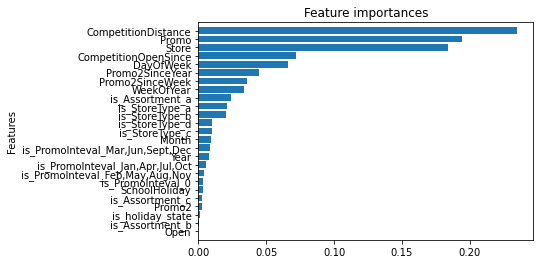

In [9]:

'''get the feature importance
regModel.regressor_ gives us the pipeline
regModel.regressor_.named_steps[randomForest] gives us the regressor''' 

importances = regModel.regressor_.named_steps['randomForest'].feature_importances_
std = np.std([regModel.regressor_.named_steps['randomForest'].feature_importances_
              for tree in regModel.regressor_.named_steps['randomForest'].estimators_], axis=0)

xPipe = regModel.regressor_.named_steps['multipleTrans'].returndf()

# rank the features
indices = np.argsort(importances)
featuresRanked = []
for f in range(xPipe.shape[1]):
    featuresRanked.append(xPipe.columns[indices[f]])

# plot the feature importance
plt.title("Feature importances")
plt.barh(range(xPipe.shape[1]), importances[indices], align="center")
plt.yticks(range(xPipe.shape[1]), featuresRanked)
plt.ylabel('Features')
plt.ylim([-1, xPipe.shape[1]])
plt.show()

 The most important features are:
- Competition Distance : the stores furtherest away from competition will make more sales than stores that are surrounded by competitors
- Promo: As we saw earlier stores that had a promo (The first one) had more sales than the ones that didn't have any all
- Store: The Store itself represents a unique identificator for the algorithm to recognise which store has what attributes and indeed better accounts for the forecasting of those same stores in a future timeline.

#### Serializing The Model

In [11]:
import pickle
import datetime

# get the current time and turn it into a string
now = datetime.datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')[:-3]

# Save the model
filenameReg = 'regModel-' + now + '.pkl'
pickle.dump(regModel, open(filenameReg, 'wb'))

In [12]:
# predict on the testStore set
predictions = regModel.predict(dfTestStore)

# turn the predictions into a dataframe
dfPreds = pd.DataFrame({'Id': Id,
                        'Sales': predictions})

# save the predictions to csv for loading in the wep app
dfPreds.to_csv('testStore.csv', index=False)

2021-07-31 10:21:17,891 : INFO  : 
 the transform function has been called 

2021-07-31 10:21:18,062 : INFO  : 
 creating the data Year, Month, Week of Year columns 

<ipython-input-5-5c323cea49e0>:32: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['WeekOfYear'] = df.index.weekofyear
2021-07-31 10:21:18,843 : INFO  : 
 running CompeSince 

2021-07-31 10:21:18,931 : INFO  : 
 running Set to Category 

2021-07-31 10:21:19,006 : INFO  : 
 Change state Holiday to 0 and 1 

2021-07-31 10:21:19,034 : INFO  : 
 Creating Dummie columns 
2021-07-31 10:21:19,167 : INFO  : 
 dropping unecessary columns 

2021-07-31 10:21:20,954 : INFO  : 
 reverse transforming the target col 



#### Time Series Prediction

In [14]:

# IMPORTING DATA 
raw_store_data=pd.read_csv('data/store.csv',low_memory=False )
raw_train_data=pd.read_csv('data/train.csv', low_memory=False, )
raw_test_data=pd.read_csv('data/test.csv',  low_memory=False,)

#copying dataframes
dfTrain = raw_train_data.copy()
dfTest = raw_test_data.copy()
dfStore = raw_store_data.copy()

# dropping the zero sales and closed stores
dfTrain = dfTrain[(dfTrain.Open != 0) & (dfTrain.Sales != 0)]

In [15]:
def prophetData(df):
    logger.info('\n Making the prophet data')
    # sales for the store number 1 (StoreType C)
    sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

    # reverse to the order: from 2013 to 2015
    sales = sales.sort_index(ascending=False)

    # to datetime64
    sales['Date'] = pd.DatetimeIndex(sales['Date'])

    # from the prophet documentation every variables should have specific names
    sales = sales.rename(columns={'Date': 'ds', 'Sales': 'y'})

    # create a holidays dataframe
    state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b')
                     & (df.StateHoliday == 'c')].loc[:, 'Date'].values
    school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

    state = pd.DataFrame({'holiday': 'state_holiday', 'ds': pd.to_datetime(state_dates)})
    school = pd.DataFrame({'holiday': 'school_holiday', 'ds': pd.to_datetime(school_dates)})

    holidays = pd.concat((state, school))

    return sales, holidays

In [19]:
from fbprophet import Prophet
# Get the data for the model
sales, holidays = prophetData(dfTrain)

# training the prophet Model
pModel = Prophet(interval_width=0.5, holidays=holidays)
pModel.fit(sales)

# dataframe that extends into future 6 weeks
future_dates = pModel.make_future_dataframe(periods=6 * 7)

# prophet model predictions
forecast = pModel.predict(future_dates)

# rename prediction columns and isolate the predictions
fc = forecast[['ds', 'yhat']].rename(columns={'Date': 'ds', 'Forecast': 'yhat'})

ModuleNotFoundError: No module named 'fbprophet'